Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s] 


Epoch 1/25 - Train Loss: 0.4353, Val Loss: 0.2328, Train Acc: 0.8658, Val Acc: 0.9276
Epoch 2/25 - Train Loss: 0.1859, Val Loss: 0.1226, Train Acc: 0.9392, Val Acc: 0.9597
Epoch 3/25 - Train Loss: 0.1379, Val Loss: 0.0886, Train Acc: 0.9554, Val Acc: 0.9694
Epoch 4/25 - Train Loss: 0.1070, Val Loss: 0.1057, Train Acc: 0.9649, Val Acc: 0.9686
Epoch 5/25 - Train Loss: 0.0832, Val Loss: 0.0703, Train Acc: 0.9726, Val Acc: 0.9779
Epoch 6/25 - Train Loss: 0.0767, Val Loss: 0.0887, Train Acc: 0.9746, Val Acc: 0.9725
Epoch 7/25 - Train Loss: 0.0594, Val Loss: 0.0691, Train Acc: 0.9806, Val Acc: 0.9780
Epoch 8/25 - Train Loss: 0.0573, Val Loss: 0.0527, Train Acc: 0.9821, Val Acc: 0.9839
Epoch 9/25 - Train Loss: 0.0492, Val Loss: 0.0758, Train Acc: 0.9846, Val Acc: 0.9793
Epoch 10/25 - Train Loss: 0.0418, Val Loss: 0.1045, Train Acc: 0.9864, Val Acc: 0.9724
Epoch 11/25 - Train Loss: 0.0405, Val Loss: 0.0674, Train Acc: 0.9869, Val Acc: 0.9775
Epoch 12/25 - Train Loss: 0.0415, Val Loss: 0.0561, 

<ipython-input-5-a378e583f5cf>:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


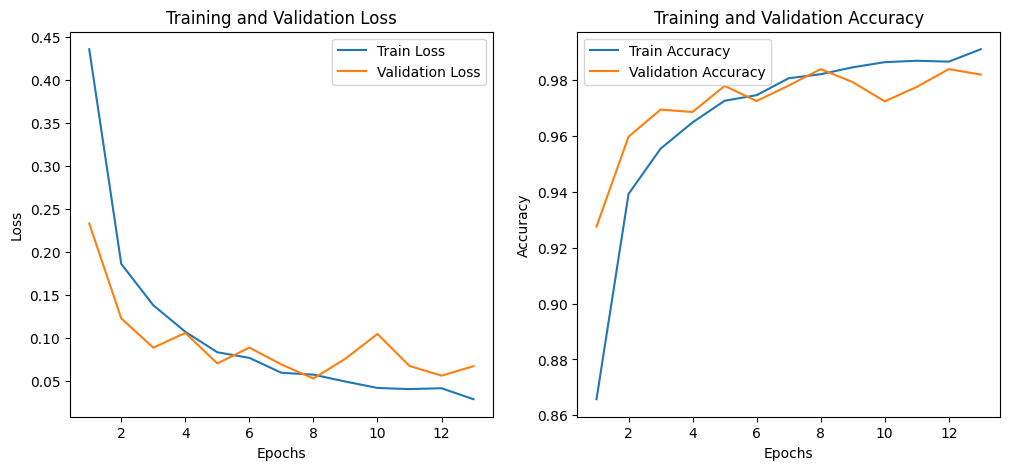

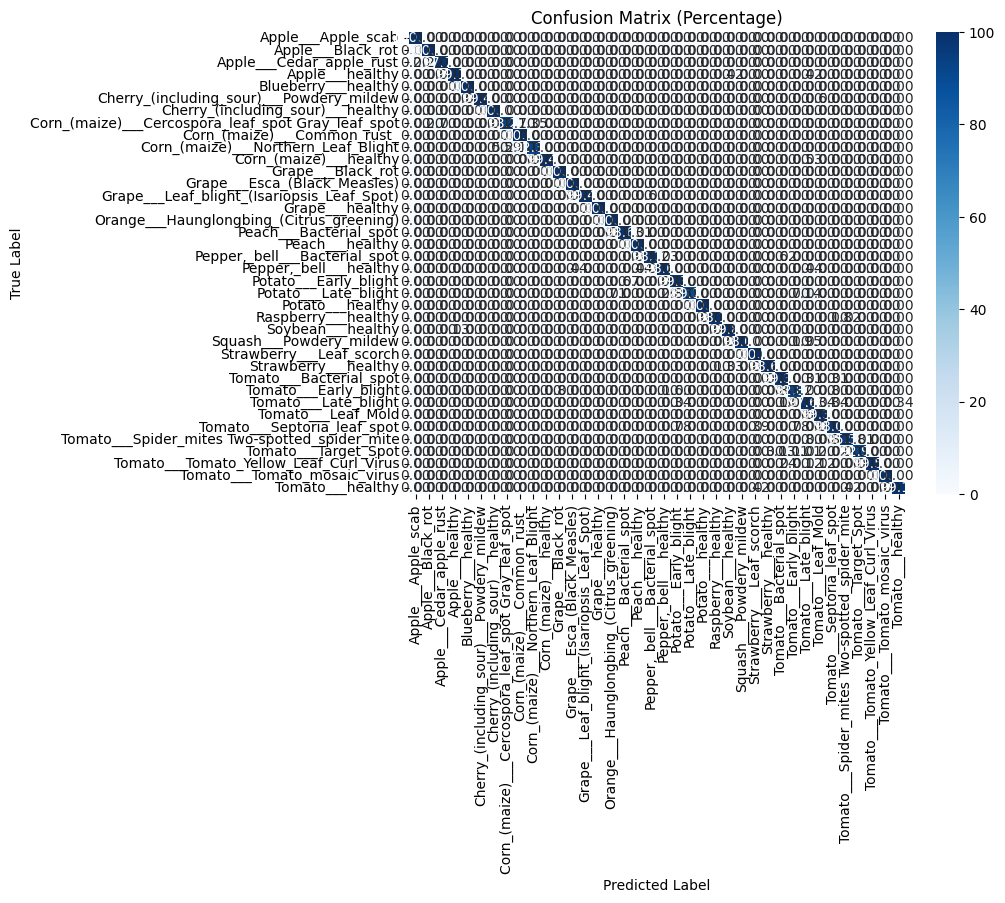

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        90
                                 Apple___Black_rot       0.99      1.00      0.99        83
                          Apple___Cedar_apple_rust       0.96      0.98      0.97        45
                                   Apple___healthy       1.00      0.99      0.99       236
                               Blueberry___healthy       1.00      1.00      1.00       214
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       167
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       144
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.93      0.91        74
                       Corn_(maize)___Common_rust_       0.97      1.00      0.99       184
               Corn_(maize)___Northern_Leaf_Blight       0.99      0.92      0.

Exception: The input image should np.float32 in the range [0, 1]

In [5]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
DATASET_PATH = "/kaggle/input/plantvillage-dataset/color"

# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE = 1e-3
PATIENCE = 5

# Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load Dataset
full_dataset = datasets.ImageFolder(DATASET_PATH, transform=data_transforms['train'])

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = data_transforms['val_test']
test_dataset.dataset.transform = data_transforms['val_test']

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class labels
class_names = full_dataset.classes
num_classes = len(class_names)

# Model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Early stopping parameters
best_val_loss = float('inf')
patience_counter = 0

# Training and Validation Loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += torch.sum(preds == labels)

    train_loss /= len(train_loader)
    train_accuracy = correct_train.double() / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy.item())

    # Validation
    model.eval()
    val_loss, correct_val = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_val += torch.sum(preds == labels)

    val_loss /= len(val_loader)
    val_accuracy = correct_val.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy.item())

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Plot Training and Validation Metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluation on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix with Percentages
cm = confusion_matrix(all_labels, all_preds)
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Percentage)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))



print("Training Complete. Model evaluation, plots, and Grad-CAM explanation generated.") 